In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.vision import *
from fastai.metrics import accuracy, error_rate

In [2]:
image_path = Path('../image-data/07-single-gray/split/left')
image_path.ls()

[PosixPath('../image-data/07-single-gray/split/left/high'),
 PosixPath('../image-data/07-single-gray/split/left/medium'),
 PosixPath('../image-data/07-single-gray/split/left/low')]

In [3]:
image_size = 256
batch_size = 64
tfms = get_transforms()

In [4]:
data = (ImageList.from_folder(image_path, convert_mode='L')
       .split_by_rand_pct()
       .label_from_folder()
       .transform(tfms, size=image_size)
       .databunch(bs=batch_size)
       .normalize()) # Optional

In [5]:
data

ImageDataBunch;

Train: LabelList (4709 items)
x: ImageList
Image (1, 256, 256),Image (1, 256, 256),Image (1, 256, 256),Image (1, 256, 256),Image (1, 256, 256)
y: CategoryList
high,high,high,high,high
Path: ../image-data/07-single-gray/split/left;

Valid: LabelList (1177 items)
x: ImageList
Image (1, 256, 256),Image (1, 256, 256),Image (1, 256, 256),Image (1, 256, 256),Image (1, 256, 256)
y: CategoryList
high,low,high,high,high
Path: ../image-data/07-single-gray/split/left;

Test: None

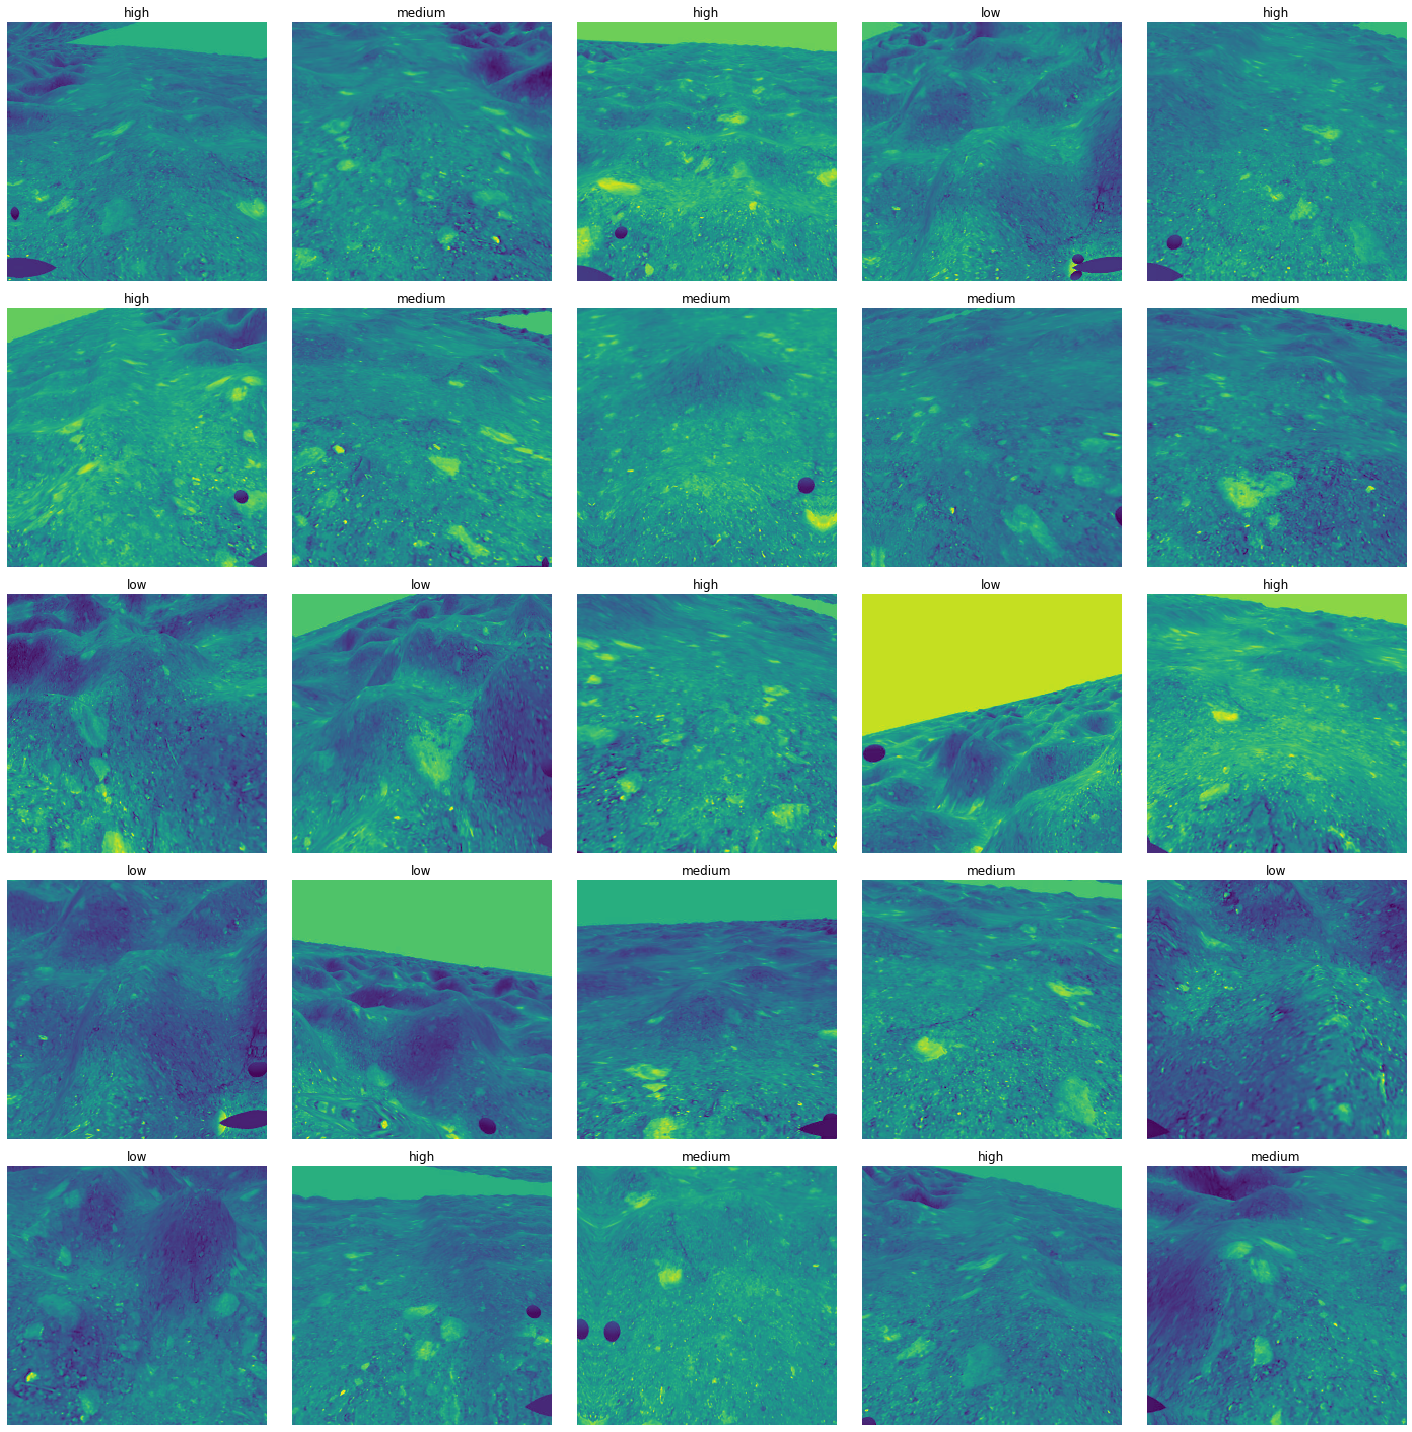

In [6]:
data.show_batch()

In [7]:
data.classes, data.c

(['high', 'low', 'medium'], 3)

In [8]:
learn = cnn_learner(data, models.resnet34, metrics=[accuracy, error_rate], pretrained=False, callback_fns=ShowGraph)
# learn = cnn_learner(data, models.resnet34, metrics=[accuracy, error_rate])
# pretrained gave lower accuracy

In [9]:
learn.model[0][0] = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
learn.model.cuda();

In [10]:
# torch.cuda.empty_cache()
# gc.collect()

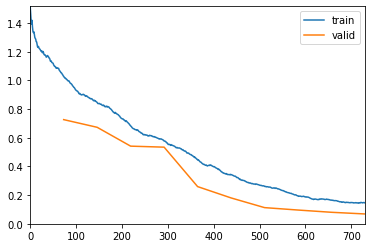

In [11]:
learn.fit_one_cycle(10)

In [12]:
learn.save('stage1-single-gray')

In [13]:
interp = ClassificationInterpretation.from_learner(learn)

losses, idxs = interp.top_losses()

len(data.valid_ds) == len(losses) == len(idxs)

True

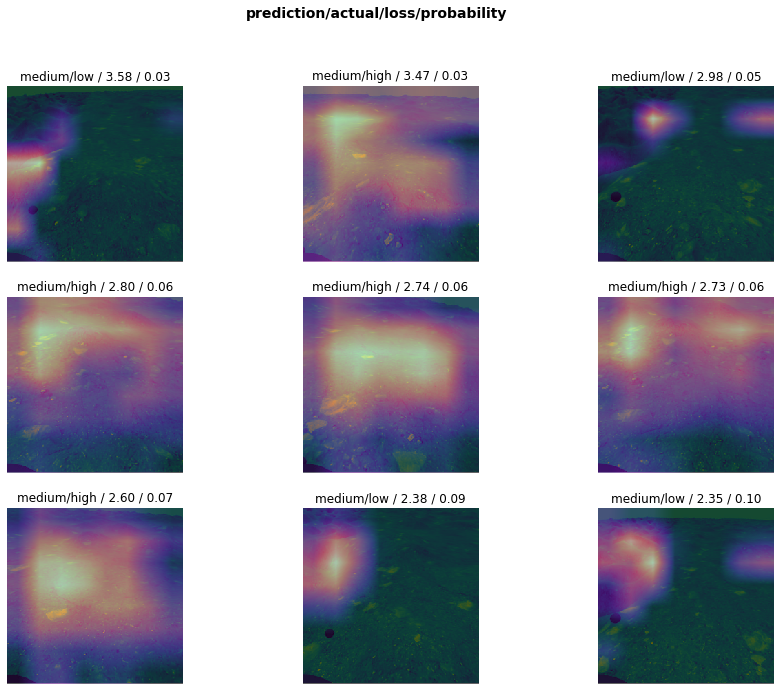

In [14]:
interp.plot_top_losses(9, figsize=(15,11))

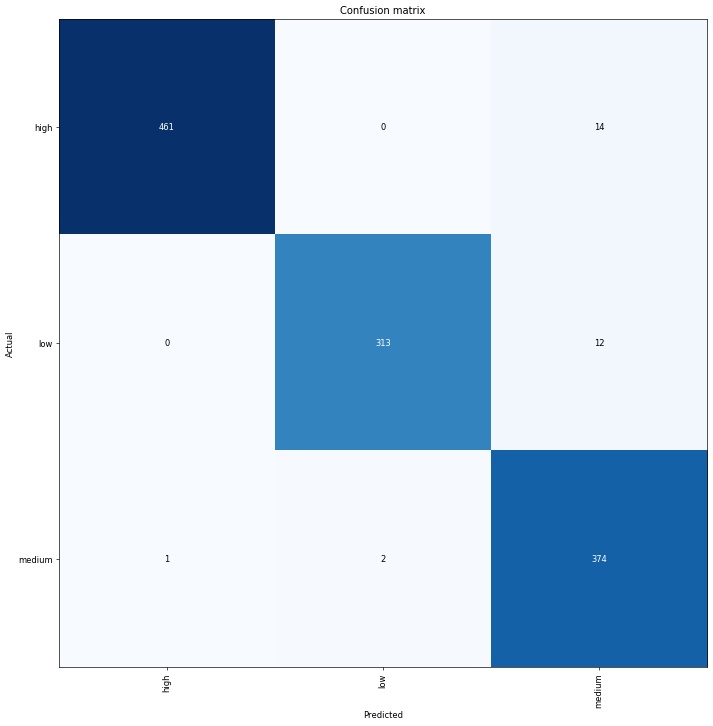

In [15]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [ ]:
learn.lr_find()

In [ ]:
learn.recorder.plot()

In [16]:
from time import time

learn.load('stage1-single-gray')
learn.model.training = False

grass_path = Path('../image-data/grass/7-gray')

grass_path.ls()

[PosixPath('../image-data/grass/7-gray/high'),
 PosixPath('../image-data/grass/7-gray/medium'),
 PosixPath('../image-data/grass/7-gray/low')]

In [18]:
# Doing this in a loop to get running times

clsses = ['high', 'medium', 'low']
totals = [0, 0, 0]
correct = [0, 0, 0]

total_time = 0

for clss_idx, clss in enumerate(clsses):
    grass_fnames = grass_path/clss
    print(grass_fnames)
    for grass_fname in grass_fnames.glob('left/*.jpg'):
        
        img = open_image(grass_fname, convert_mode='L')
        
        tstart = time()
        pred = learn.predict(img)
        total_time += time() - tstart
        
        if str(pred[0]) == clss:
            correct[clss_idx] += 1
        totals[clss_idx] += 1
print('done')

../image-data/grass/7-gray/high
../image-data/grass/7-gray/medium
../image-data/grass/7-gray/low
done


In [19]:
print(correct)
print(totals)
print([c/t*100 for c, t in zip(correct, totals)])
print(sum(correct)/sum(totals)*100)
print(total_time)

[115, 258, 34]
[284, 295, 295]
[40.49295774647887, 87.45762711864407, 11.525423728813559]
46.567505720823796
5.0158162117004395
